# Infer ***lysosome*** -  4️⃣

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component ***lysosome***  in order to understand interactome 

Infer the shape of the lysosomes in order to measure their extent, shape, position, and size.

Dependencies:
The ***lysosome***  inference rely on the ***cytosol*** mask.


## preamble

1. imports
2. setup
3. choose_Z
4. get soma mask
5. infer nuclei object  
6. get cytosol mask


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional

import numpy as np

from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.pre_processing_utils import       image_smoothing_gaussian_slice_by_slice 
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    list_image_files)
from infer_subc_2d.utils.img import *

from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )          

from infer_subc_2d.organelles import fixed_infer_soma, fixed_infer_nuclei, infer_cytosol, find_optimal_Z

%load_ext autoreload
%autoreload 2

test_img_n = TEST_IMG_N


## SETUP

In [2]:
# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]


In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

... and get the single "optimal" slice of all our organelle channels....

In [5]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 
img_2D = select_z_from_raw(img_data, optimal_Z)


choosing _optimal_ z-slice::: 8


## GET SOMA MASK

Find the soma in our chozed Z-slice

In [6]:
soma_mask =  fixed_infer_soma(img_2D) 

## INFER NUCLEI OBJECT


In [ ]:
nuclei_object =  fixed_infer_nuclei(img_2D, soma_mask) 


## GET CYTOSOL MASK


In [ ]:
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


---------------------

## infer ***lysosome***

## summary of steps (Workflow #1 & #2)

INPUT
- channel  2
- cytosol mask

PRE-PROCESSING
-  smooth / remove noise

CORE-PROCESSING
- enhance two classes of "spots"
-  segment objects

POST-PROCESSING
  - filter objects

OUTPUT
- object ***lysosome*** 


Generally following the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

> Using Allen Cell Segmenter LAMP1 [workflow](https://www.allencell.org/cell-observations/category/lamp1).  Examples sourced from: [Notebook](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/lookup_table_demo/playground_lamp1.ipynb) and [script](/Users/ahenrie/Projects/Imaging/mcz_subcell/napari/aics-segmentation/aicssegmentation/structure_wrapper/seg_lamp1.py)



## INPUT prototype

In [10]:

###################
# INPUT
###################
raw_lyso = select_channel_from_raw(img_2D, LYSO_CH)


## PRE-PROCESSING prototype


In [11]:
###################
# PRE_PROCESSING
###################

# Linear-ish smoothing
lysosome = min_max_intensity_normalization( raw_lyso)

med_filter_size = 3   
structure_img_median = median_filter_slice_by_slice( lysosome, size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(  structure_img_median,
                                                                                            sigma=gaussian_smoothing_sigma,
                                                                                            truncate_range = gaussian_smoothing_truncate_range )

struct_img = structure_img_smooth

## CORE PROCESSING prototype

In [12]:
###################
# CORE_PROCESSING
###################
# dot and filiment enhancement - 2D

################################
## PARAMETERS for this step ##
s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
################################
bw_spot = dot_2d_slice_by_slice_wrapper(struct_img, s2_param)


################################
## PARAMETERS for this step ##
f2_param = [[1, 0.15]]
################################
bw_filament = filament_2d_wrapper(struct_img, f2_param)
bw = np.logical_or(bw_spot, bw_filament)



### POST-PROCESSING

> NOTE: we are using the 3D aicssegmentation functions which wrap `scipy.ndimage` functions with a single Z rather than the `scipy.ndimage` functions directly

In [13]:
###################
# POST_PROCESSING
###################

################################
## PARAMETERS for this step ##
fill_2d = True
fill_max_size = 25
hole_min = 0
################################

removed_holes = hole_filling(bw, hole_min ** 2, fill_max_size ** 2, fill_2d)


masked_img = apply_mask(removed_holes, cytosol_mask)

width = 3  
# cleaned_img = size_filter(removed_holes, # wrapper to remove_small_objects which can do slice by slice
#                                                          min_size= width**2, 
#                                                          method = "slice_by_slice" ,
#                                                          connectivity=1)

cleaned_img = size_filter_2D(masked_img, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= width ** 2, 
                                                         connectivity=1)


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [7]:
viewer = napari.Viewer()
viewer.add_image(soma_mask,
    scale=scale)
viewer.add_image(nuclei_object,
    scale=scale)
viewer.add_image(cytosol_mask,
    scale=scale)    

<Image layer 'nuclei_object' at 0x1663bb130>

In [14]:

viewer.add_image(
    removed_holes,
    scale=scale
)
viewer.add_image(
    masked_img,
    scale=scale
)


<Image layer 'masked_img' at 0x17304f760>

In [15]:

viewer.scale_bar.visible = True
viewer.add_image(
    cleaned_img,
    scale=scale
)
viewer.add_image(
    structure_img_smooth,
    scale=scale
)

<Image layer 'structure_img_smooth' at 0x171a4d4f0>

## DEFINE `_infer_lysosome` function

Based on the _prototyping_ above define the function to infer the lysosomes.  



In [16]:
##########################
#  infer_LYSOSOMES
##########################
def _infer_lysosome(
                                in_img: np.ndarray,
                                cytosol_mask: np.ndarray,
                                median_sz: int,
                                gauss_sig: float,
                                dot_scale_1: float,
                                dot_cut_1: float,
                                dot_scale_2: float,
                                dot_cut_2: float,
                                dot_scale_3: float,
                                dot_cut_3: float,
                                filament_scale : float,
                                filament_cut : float,
                                min_hole_w: int,
                                max_hole_w: int,
                                small_obj_w: int,
                            ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input,
    
    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cytosol_mask: 
        mask
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    filament_scale: 
        scale (log_sigma) for filament filter
    filament_cut: 
        threshold for filament fitered threshold
    min_hole_w: 
        hole filling min for nuclei post-processing
    max_hole_w: 
        hole filling cutoff for nuclei post-processing
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    lysosome_object
        mask defined extent of lysosome object

    """
    lyso_ch = LYSO_CH
    ###################
    # EXTRACT
    ###################    
    lyso = select_channel_from_raw(in_img, lyso_ch)

     ###################
    # PRE_PROCESSING
    ###################    
    lyso = min_max_intensity_normalization(lyso)

    lyso = median_filter_slice_by_slice(lyso, size=median_sz)

    lyso = image_smoothing_gaussian_slice_by_slice(lyso, sigma=gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    # s2_param = [[5,0.09], [2.5,0.07], [1,0.01]]
    s2_param = [    
                [dot_scale_1, dot_cut_1],
                [dot_scale_2, dot_cut_2],
                [dot_scale_3, dot_cut_3]
                ]
    bw_spot = dot_2d_slice_by_slice_wrapper(lyso, s2_param)

    f2_param = [[filament_scale, filament_cut]]
    # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
    bw_filament = filament_2d_wrapper(lyso, f2_param)

    bw = np.logical_or(bw_spot, bw_filament)

    ###################
    # POST_PROCESSING
    ###################

    struct_obj = hole_filling(bw, hole_min = min_hole_w **2 , hole_max=max_hole_w**2, fill_2d = True) 

    struct_obj = apply_mask(struct_obj, cytosol_mask)

    struct_obj = size_filter_2D(struct_obj, 
                                                                min_size= small_obj_w**2, 
                                                                connectivity=1)
                
    return struct_obj

In [17]:


##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_lysosome(in_img: np.ndarray, 
                                                cytosol_mask: Optional[np.ndarray] = None
                                            ) -> np.ndarray:
    """
    Procedure to infer lysosome from linearly unmixed input with *fixed parameters*
    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    cytosol_mask: Optional[np.ndarray] = None
        mask

    Returns
    -------------
    lysosome_object
        mask defined extent of NU
    """
    median_sz = 4
    gauss_sig = 1.34
    dot_scale_1 = 5
    dot_cut_1 = 0.09
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 1
    dot_cut_3 = 0.01
    filament_scale = 1
    filament_cut = 0.15
    min_hole_w = 0
    max_hole_w = 25
    small_obj_w = 3

    return _infer_lysosome(  in_img,
                                cytosol_mask,
                                median_sz,
                                gauss_sig,
                                dot_cut_1,
                                dot_scale_1,
                                dot_cut_2,
                                dot_scale_2,
                                dot_cut_3,
                                dot_scale_3,
                                filament_scale,
                                filament_cut ,
                                min_hole_w,
                                max_hole_w,
                                small_obj_w)


------------------

# TEST `_infer_lysosome` function

In [18]:

_lysosome_object =  _fixed_infer_lysosome(img_2D, cytosol_mask) 



In [19]:
from infer_subc_2d.organelles.lysosome import fixed_infer_lysosome

lysosome_object =  fixed_infer_lysosome(img_2D, cytosol_mask) 



In [20]:

viewer.add_image(
    _lysosome_object,
    scale=scale
)
viewer.add_labels(
    label(lysosome_object),
    scale=scale
)
viewer.add_image(
    lysosome_object,
    scale=scale
)

<Image layer 'lysosome_object' at 0x171650f70>

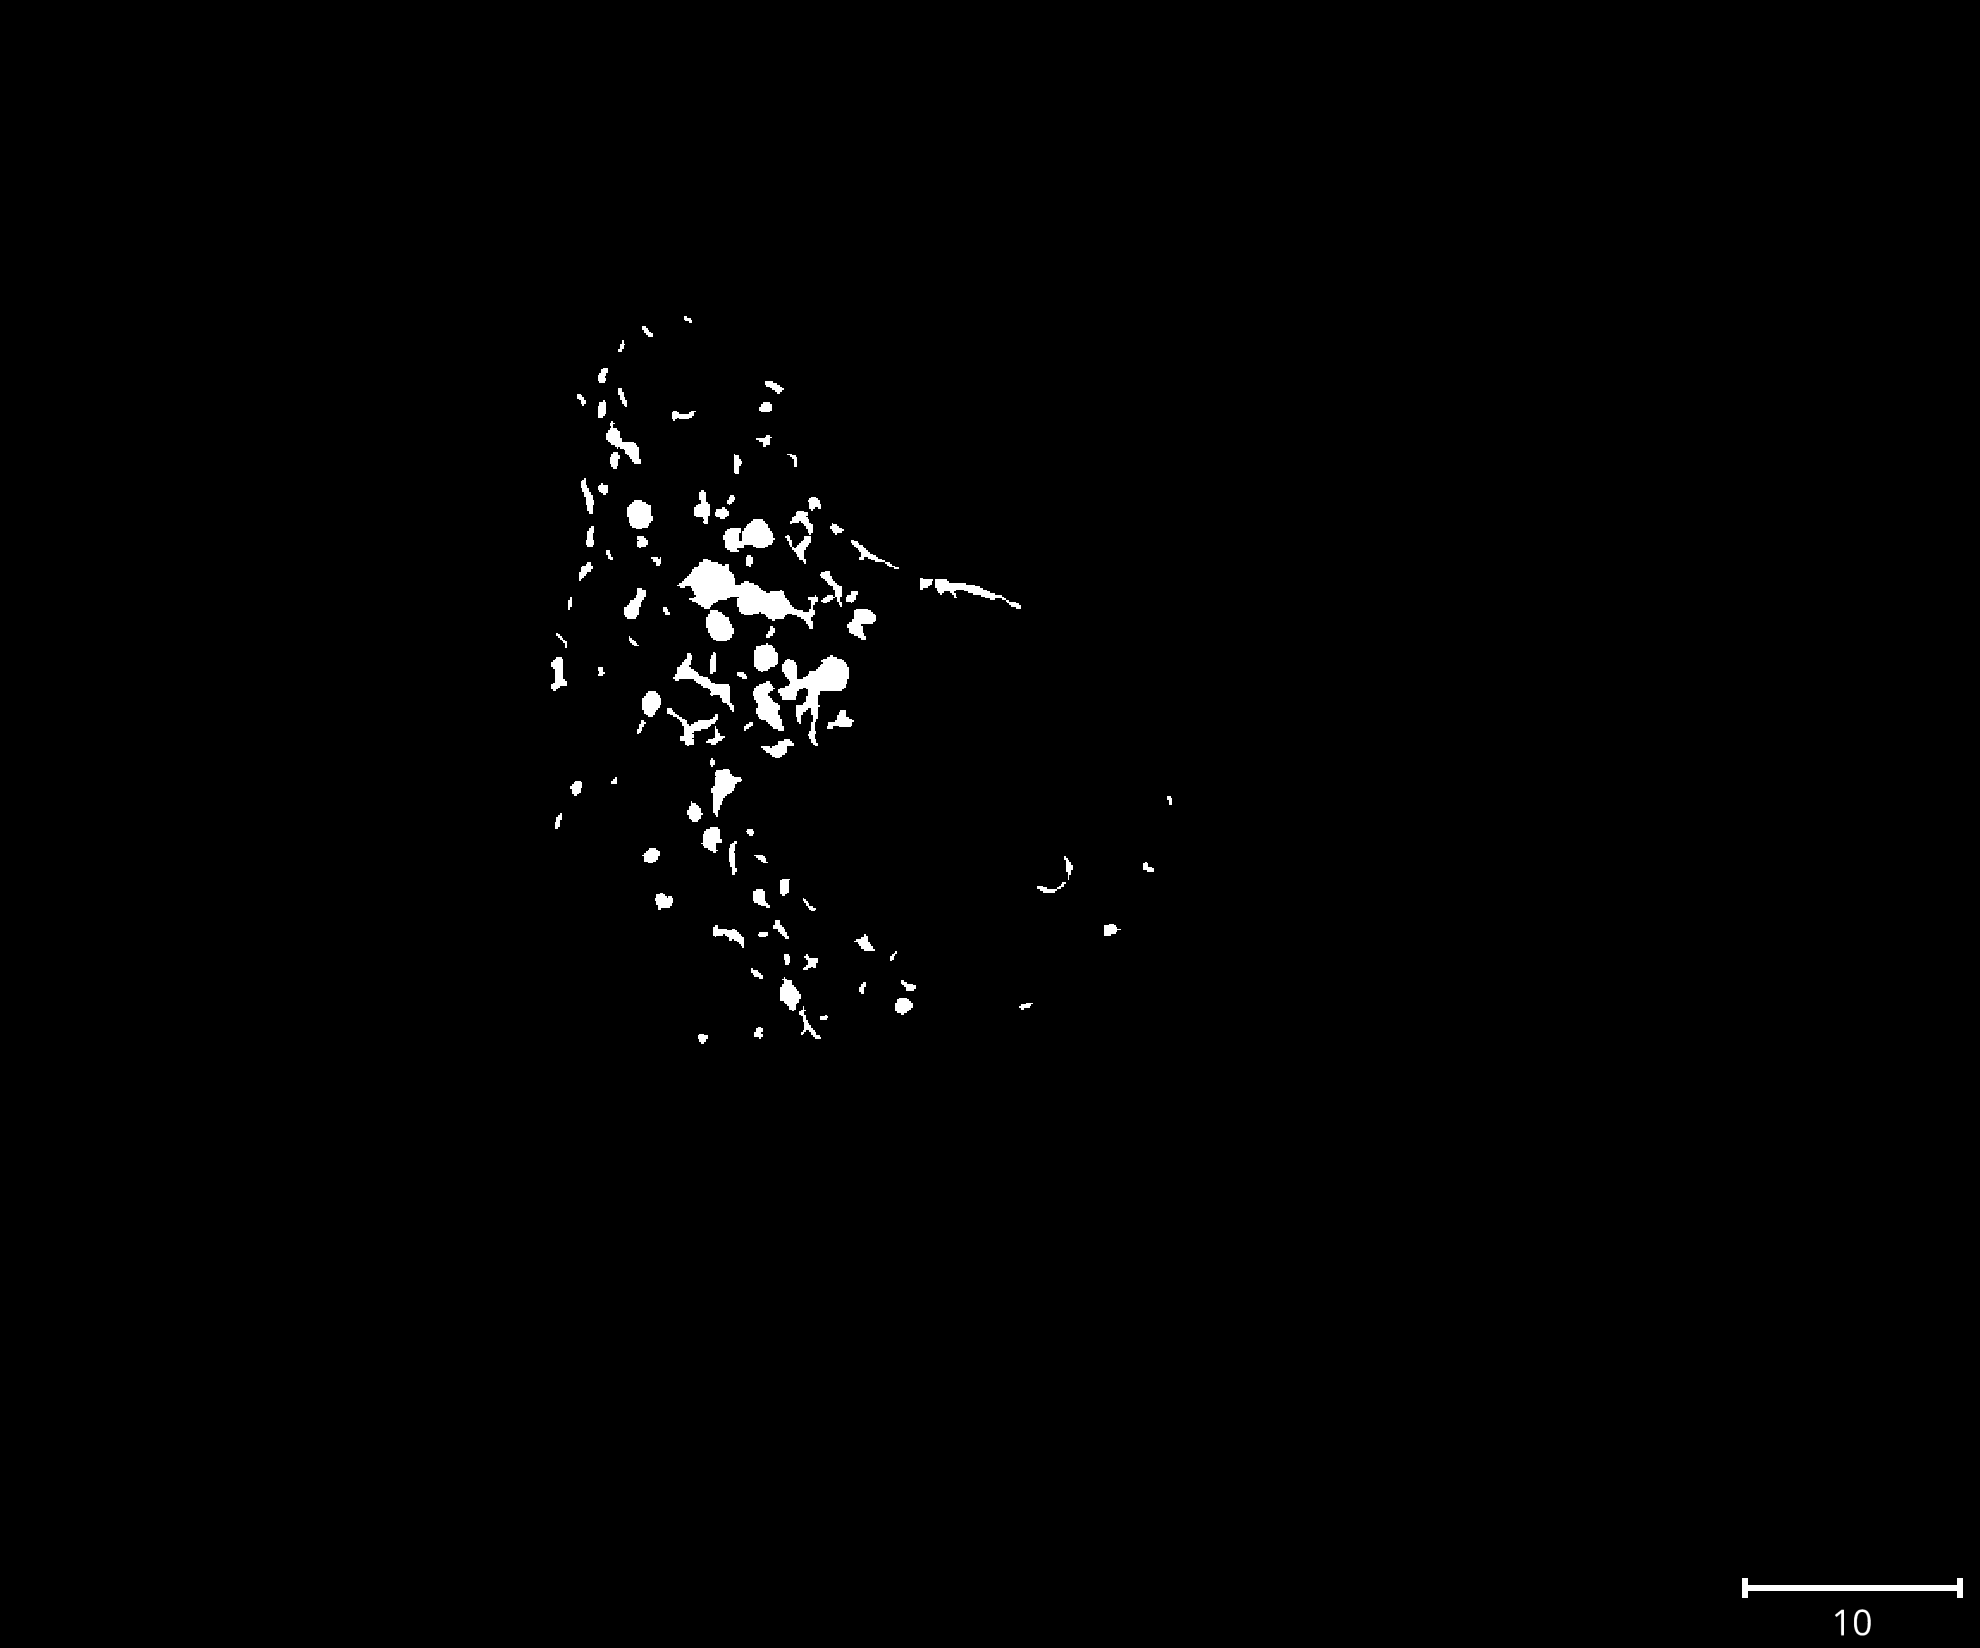

In [21]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

-----------------
## make function json to add to `all_functions.json`
### infer_lysosome 

In [31]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_lysosome =  {
        "name": "infer lysosome  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_lysosome",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_lysosome",_fixed_infer_lysosome)

function fixed_infer_lysosome is already in all_functions.json


0

In [32]:

_infer_lysosome =  {
        "name": "infer lysosome",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_lysosome",
        "parameters": {
                "median_sz": {
                        "widget_type": "slider",
                        "data_type": "int",
                        "min": 3,
                        "max": 15,
                        "increment": 1
                },
                "gauss_sig": {
                        "data_type": "float",
                        "increment": 0.25,
                        "max": 15.0,
                        "min": 1.25,
                        "widget_type": "slider"
                },
                "dot_scale_1": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_1": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_scale_2": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_2": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_scale_3": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "dot_cut_3": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_scale": {
                        "data_type": "float",
                        "increment": 0.05,
                        "max": 10,
                        "min": 0,
                        "widget_type": "slider"
                },
                "filament_cut": {
                        "data_type": "float",
                        "increment": 0.001,
                        "max": 0.5,
                        "min": 0,
                        "widget_type": "slider"
                },
                "min_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 30,
                        "min": 0,
                        "widget_type": "slider"
                },    
                "max_hole_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 40,
                        "min": 4,
                        "widget_type": "slider"
                },           
                "small_obj_w": {
                        "data_type": "int",
                        "increment": 1,
                        "max": 50,
                        "min": 1,
                        "widget_type": "slider"
                }
        }
}

add_function_spec_to_widget_json("infer_lysosome", _infer_lysosome, overwrite=True )



function infer_lysosome is already in all_functions.json
overwriting  infer_lysosome


1

## a couple helper function

Wrappers for spot and filiment filters

In [33]:

def _lysosome_spot_filter(in_img: np.ndarray) -> np.ndarray:
    """ spot filter helper function for lysosome """
    dot_scale_1 = 5
    dot_cut_1 = 0.09
    dot_scale_2 = 2.5
    dot_cut_2 = 0.07
    dot_scale_3 = 1
    dot_cut_3 = 0.01
    s2_param = [[dot_scale_1, dot_cut_1], [dot_scale_2, dot_cut_2], [dot_scale_3, dot_cut_3]]
    return dot_2d_slice_by_slice_wrapper(in_img, s2_param)

# def _lysosome_filiment_filter(in_img: np.ndarray) -> np.ndarray:
#     """ spot filter helper function for lysosome  (DEPRICATED)"""
#     f2_param = [[filament_scale, filament_cut]]
#     # f2_param = [[1, 0.15]]  # [scale_1, cutoff_1]
#     return filament_2d_wrapper(in_img, f2_param)



In [34]:
_lysosome_spot_filter =  {
        "name": "lysosome spot filter",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "lysosome_spot_filter",
        "parameters": None
        }

add_function_spec_to_widget_json("lysosome_spot_filter",_lysosome_spot_filter, overwrite=True)

function lysosome_spot_filter is already in all_functions.json
overwriting  lysosome_spot_filter


1

In [35]:
_lysosome_filiment_filter =  {
        "name": "lysosome filiment filter",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "lysosome_filiment_filter",
        "parameters": None
        }

add_function_spec_to_widget_json("lysosome_filiment_filter",_lysosome_filiment_filter)

function lysosome_filiment_filter is already in all_functions.json


0

In [36]:
_logical_or =  {
        "name": "logical or",
        "python::module": "numpy",
        "python::function": "logical_or",
        "parameters": None
        }

add_function_spec_to_widget_json("logical_or",_logical_or)

function logical_or is already in all_functions.json


0

In [37]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_fixed_infer_nuclei =  {
        "name": "infer nuclei  (fixed parameters)",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "fixed_infer_nuclei",
        "parameters": None
        }

add_function_spec_to_widget_json("fixed_infer_nuclei",_fixed_infer_nuclei)

function fixed_infer_nuclei is already in all_functions.json


0

In [38]:


    # NU_labels = label(nuclei_object)

_label =  {
        "name": "label objects",
        "python::module": "skimage.measure",
        "python::function": "label",
        "parameters": None
        }
# json.dumps({"label":_label})
add_function_spec_to_widget_json("label",_label)        


function label is already in all_functions.json


0

## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [39]:
from infer_subc_2d.constants import LYSO_CH
def make_infer_lysosome_step_by_step_from_raw_dict():
    """
    Procedure to infer lysosome from linearly unmixed input from raw

    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_get_optimal_Z_img")
    category.append("extraction")
    parameter_values.append(None)
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(1)

    step_name.append("3")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("extraction")
    parameter_values.append(dict(erode_nuclei = True ))
    parent.append([2,3])

    step_name.append("5")
    function_name.append("select_channel_from_raw")
    category.append("extraction")
    parameter_values.append( dict(chan = LYSO_CH) )
    parent.append(1)
    
    step_name.append("6")
    function_name.append("min_max_intensity_normalization")
    category.append("preprocessing")
    parameter_values.append(None)
    parent.append(5)

    step_name.append("7")
    function_name.append("median_filter_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict(size = 4 ))
    parent.append(6)

    step_name.append("8")
    function_name.append("image_smoothing_gaussian_slice_by_slice")
    category.append("preprocessing")
    parameter_values.append(dict( sigma = 1.34 ))
    parent.append(7)


    step_name.append("9")
    function_name.append("lysosome_spot_filter")
    category.append("core")
    parameter_values.append( None )
    parent.append(8)

    # step_name.append("10")
    # function_name.append("lysosome_filiment_filter")
    # category.append("core")
    # parameter_values.append( None )
    # parent.append(8)
    step_name.append("10")
    function_name.append("filament_filter") 
    category.append("core")
    parameter_values.append( dict( filament_scale=1., filament_cut=.15) )
    parent.append(8)

    step_name.append("11")
    function_name.append("logical_or")
    category.append("core")
    parameter_values.append( None )
    parent.append([9,10])

    step_name.append("12")
    function_name.append("hole_filling")
    category.append("postprocessing")
    parameter_values.append(dict( hole_min=0, hole_max=25**2, fill_2d=True))
    parent.append(11)

    step_name.append("13")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([12,4])

    step_name.append("14")
    function_name.append("size_filter_2D")
    category.append("postprocessing")
    parameter_values.append(dict( min_size = 3**2  ))
    parent.append(13)

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
    
    return out_dict

In [40]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_lysosome_stepbystep_from_raw_dict = make_infer_lysosome_step_by_step_from_raw_dict()

write_workflow_json("conf_1.4.lysosome_stepbystep_from_raw", infer_lysosome_stepbystep_from_raw_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.4.lysosome_stepbystep_from_raw.json')

In [41]:
viewer.close()

: 